# GlueStick Image Matching Demo 🖼️💥🖼️


In this python notebook we show how to obtain point and line matches using GlueStick. GlueStick is a unified pipeline that uses a single GNN to process both types of features and predicts coherent point and line matched that help each other in the matching process.

![](https://iago-suarez.com/gluestick/static/images/method_overview2.svg)

If you use this python notebook please cite our work:

> Pautrat, R.* and Suárez, I.* and Yu, Y. and Pollefeys, M. and Larsson, V. (2023). "GlueStick: Robust Image Matching by Sticking Points and Lines Together". ArXiv preprint.

In [1]:
# Download the repository
!git clone https://github.com/cvg/GlueStick.git
%cd GlueStick

Cloning into 'GlueStick'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 3), reused 24 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), 30.89 MiB | 8.17 MiB/s, done.
/content/GlueStick


In [2]:
# Install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/iago-suarez/pytlsd.git (to revision d518527) to /tmp/pip-req-build-u60qtkws
  Running command git clone --filter=blob:none --quiet https://github.com/iago-suarez/pytlsd.git /tmp/pip-req-build-u60qtkws
  Running command git checkout -q d518527
  Resolved https://github.com/iago-suarez/pytlsd.git to commit d518527
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 KB 404.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=ac7a12e0ddab8ea2fd70b57eab16afa268aba7e11

Download the pre-trained model

In [1]:
!wget https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar -P resources/weights

^C


In [4]:
from os.path import join

import cv2
import torch
from matplotlib import pyplot as plt

from gluestick import batch_to_np, numpy_image_to_torch, GLUESTICK_ROOT
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches
from gluestick.models.two_view_pipeline import TwoViewPipeline

Define the configuration and model that we are going to use in our demo:

In [5]:
MAX_N_POINTS, MAX_N_LINES = 1000, 300

# Evaluation config
conf = {
    'name': 'two_view_pipeline',
    'use_lines': True,
    'extractor': {
        'name': 'wireframe',
        'sp_params': {
            'force_num_keypoints': False,
            'max_num_keypoints': MAX_N_POINTS,
        },
        'wireframe_params': {
            'merge_points': True,
            'merge_line_endpoints': True,
        },
        'max_n_lines': MAX_N_LINES,
    },
    'matcher': {
        'name': 'gluestick',
        'weights': str(GLUESTICK_ROOT / 'resources' / 'weights' / 'checkpoint_GlueStick_MD.tar'),
        'trainable': False,
    },
    'ground_truth': {
        'from_pose_depth': False,
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline_model = TwoViewPipeline(conf).to(device).eval()
pipeline_model

TwoViewPipeline(
  (extractor): SPWireframeDescriptor(
    (sp): SuperPoint(
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPb): Conv2d(256, 65, kernel_size=(1, 1), str

In [6]:
# Load input images 
import sys

IN_COLAB = 'google.colab' in sys.modules
if not IN_COLAB:
    # We are running a notebook in Jupyter
    img_path0 = join('resources', 'img1.jpg')
    img_path1 = join('resources', 'img2.jpg')
else:
    # We are running in Colab: Load from user's disk using Colab tools
    from google.colab import files
    print('Choose the FIRST image from your computer (Recommended resolution: 640x640)')
    uploaded_files = files.upload()
    img_path0 = list(uploaded_files.keys())[0]
    print('Choose the SECOND image from your computer')
    uploaded_files = files.upload()
    img_path1 = list(uploaded_files.keys())[0]

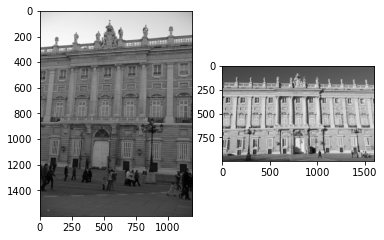

In [7]:
img = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)

gray0 = cv2.imread(img_path0, 0)
gray1 = cv2.imread(img_path1, 0)

# Plot them using matplotlib
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gray0, cmap='gray')
axarr[1].imshow(gray1, cmap='gray')

In [8]:
# Convert images into torch and execute GlueStick💥

torch_gray0, torch_gray1 = numpy_image_to_torch(gray0), numpy_image_to_torch(gray1)
torch_gray0, torch_gray1 = torch_gray0.to(device)[None], torch_gray1.to(device)[None]
x = {'image0': torch_gray0, 'image1': torch_gray1}
pred = pipeline_model(x)

In [9]:
print(f"Detected Keypoints: {pred['keypoints0'].shape[1]} img1, {pred['keypoints1'].shape[1]} img2")
print(f"Detected Lines: {pred['lines0'].shape[1]} img1, {pred['lines1'].shape[1]} img2\n")
print(f"Matched {(pred['matches0'] >= 0).sum()} points and {(pred['line_matches0'] >= 0).sum()} lines")

Detected Keypoints: 1557 img1, 1556 img2
Detected Lines: 300 img1, 300 img2

Matched 446 points and 110 lines


In [16]:
pred['lines0'].shape

(300, 2, 2)

Show some matches

In [10]:
pred = batch_to_np(pred)
kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
m0 = pred["matches0"]

line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
line_matches = pred["line_matches0"]

valid_matches = m0 != -1
match_indices = m0[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]

valid_matches = line_matches != -1
match_indices = line_matches[valid_matches]
matched_lines0 = line_seg0[valid_matches]
matched_lines1 = line_seg1[match_indices]

## Detected Lines

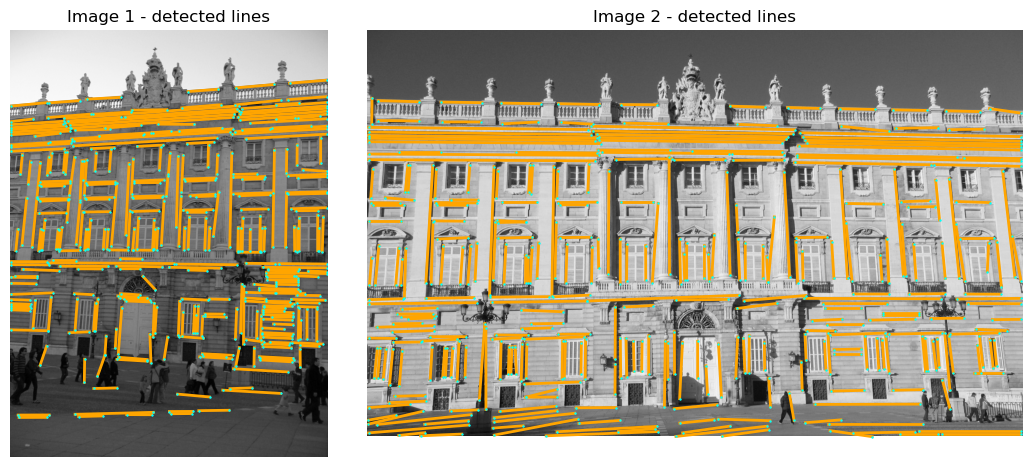

In [11]:
img0, img1 = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR), cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)
plot_images([img0, img1], ['Image 1 - detected lines', 'Image 2 - detected lines'], pad=0.5)
plot_lines([line_seg0, line_seg1], ps=3, lw=2)

## Detected Points 

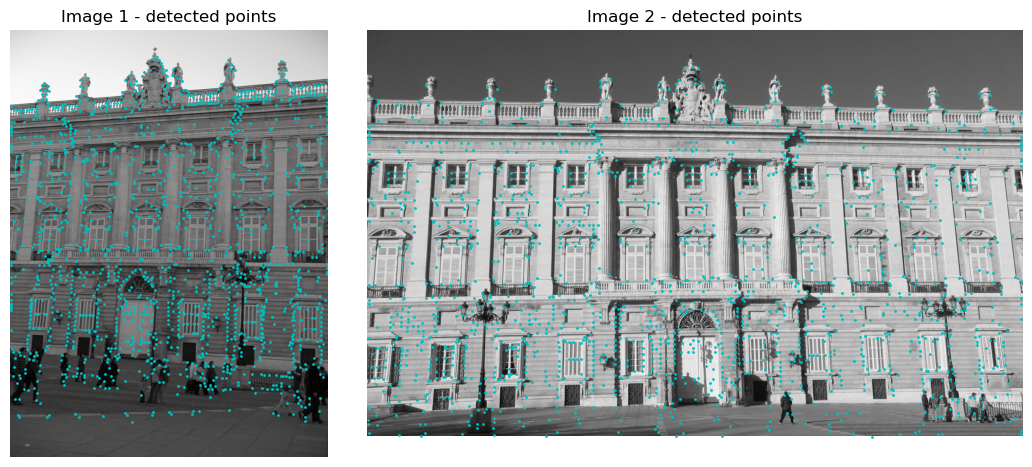

In [12]:
plot_images([img0, img1], ['Image 1 - detected points', 'Image 2 - detected points'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

## Matched Lines
(Each match has a different color) 

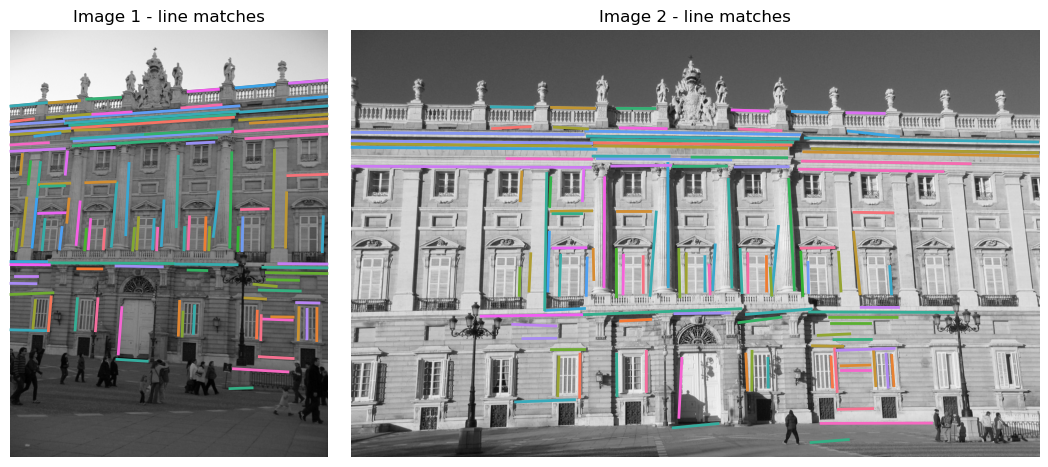

In [13]:
plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_color_line_matches([matched_lines0, matched_lines1], lw=2)

## Matched Points

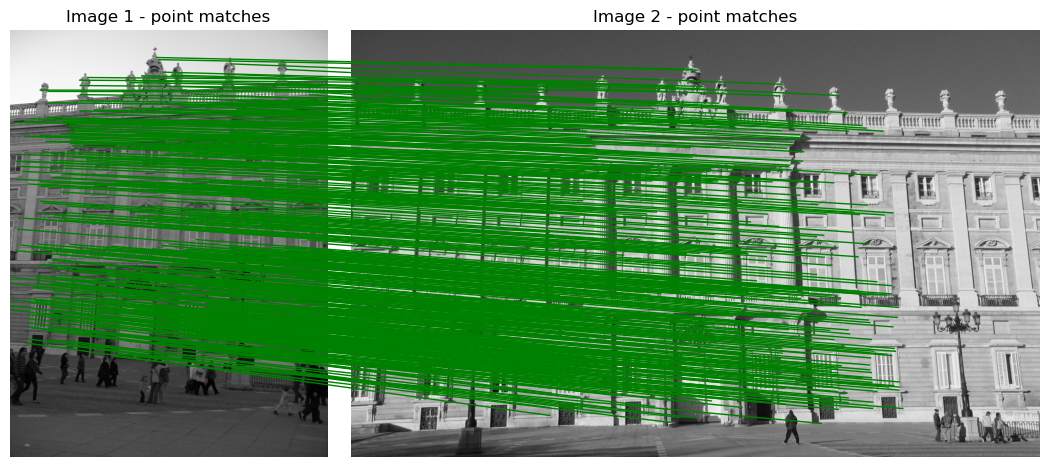

In [14]:
plot_images([img0, img1], ['Image 1 - point matches', 'Image 2 - point matches'], pad=0.5)
plot_matches(matched_kps0, matched_kps1, 'green', lw=1, ps=0)